## Assignment 3:  Convolutional networks for TF ChIP-seq data

In this assignment you will build on the convolutional networks we looked at in class and work on ChIP-seq data for four transcription factors in arabidopsis.


### Part 1: Data Preparation

In this assignment you will work with ChIP-seq for three arabidopsis transcription factors:  AGL16, GRF1, and AMS.  The peaks that represent their binding sites in the arabidopsis genome are available in the following links:

* AGL16 ([bed file](https://biobigdata.nju.edu.cn/ChIPHub_download/arabidopsis_thaliana/SRP187795/hammock/AGL16.target.all.bed.gz))
* GRF1 ([bed file](https://biobigdata.nju.edu.cn/ChIPHub_download/arabidopsis_thaliana/SRP002566/hammock/SRX021610.peak.all.bed.gz))
* AMS ([bed file](https://biobigdata.nju.edu.cn/ChIPHub_download/arabidopsis_thaliana/SRP188198/hammock/SRX5507861.peak.all.bed.gz))

These files are in [bed format](https://en.wikipedia.org/wiki/BED_(file_format)), and contain the information on the genomic locations where the ChIP-seq peaks have been detected.  The linked wikipedia article provides the information you need about the format of these files.  Your task is to extract sequences of length 500 centered at the location of each peak, which you will provide as input to the convolutional network you train.  

In order to extract the sequences associated with the peaks you will need the genomic sequence for arabidopsis.  This is available from the [Ensembl plants arabidopsis portal](https://plants.ensembl.org/Arabidopsis_thaliana/Info/Index).  In that page click on "Download DNA sequence (FASTA)", and the first five files provide the sequences for the five arabidopsis chromosomes.

For reference, we computed the sequences associated with AGL16 peaks (link is in the assignment page in Canvas).

Your final data preparation task is to prepare a labeled dataset with positive examples that correspond to the peak sequences.  As negative examples, use random permutations of the positive examples.  Create one permutation from each positive example.  How many examples did you obtain for each transcription factor?

In [1]:
# Task
# - Load data
# given bed file -> convert to fasta file (example database\AGL16_peak_seq.fasta)
# - Generate dataset
# given a fasta file -> a dataset with negative example made from postive

In [2]:
# lets look at the bed files 
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

positions = {}
with open('database\AGL16.target.all.bed') as f:
    for line in f:
        chr, start, stop, name, score, strand, thickStart, thickEnd, itemRgb, blockcount, blockSize, blockStart, _, _ = line.split()
        # idk what the last two are there is only supposed to be 12 according to wikipedia
        positions[name] = (chr, int(start), int(stop), (int(start)+int(stop))//2)

genome_locations = [r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.1.fa',
                    r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.2.fa',
                    r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.3.fa',
                    r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.4.fa',
                    r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.5.fa']
genome = {}
for l in genome_locations:
    genome = genome | SeqIO.to_dict(SeqIO.parse(open(l), 'fasta'), lambda rec: 'Chr'+rec.name)

# Extract 500bp sequences centered at midpoints
sequences = []
for name, (chr, start, stop, mid_point) in positions.items():
    # Calculate the start and end positions for a 500bp sequence centered at midpoint
    seq_start = max(0, mid_point - 250)  # Ensure we don't go below 0
    seq_end = min(len(genome[chr].seq), mid_point + 250)  # Ensure we don't go beyond chromosome length
    
    # Extract the sequence
    sequence = genome[chr].seq[seq_start:seq_end]
    
    # Create a SeqRecord
    record = SeqRecord(sequence, id=name, description=f"Chromosome {chr}, midpoint {mid_point}")
    sequences.append(record)

# Write to FASTA file
SeqIO.write(sequences, "AGL16_peak_seq.fasta", "fasta")
print(f"Extracted {len(sequences)} sequences and saved to FASTA file.")




<>:7: SyntaxWarning: invalid escape sequence '\A'
<>:7: SyntaxWarning: invalid escape sequence '\A'
c:\temp\ipykernel_18640\2856302313.py:7: SyntaxWarning: invalid escape sequence '\A'
  with open('database\AGL16.target.all.bed') as f:


Extracted 4328 sequences and saved to FASTA file.


In [ ]:
import os
import numpy as np
from Bio import SeqIO

def get_sequences(genome_paths = [r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.1.fa',
                                r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.2.fa',
                                r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.3.fa',
                                r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.4.fa',
                                r'database\Arabidopsis_thaliana.TAIR10.dna.chromosome.5.fa'], 
                                bed_path='database\AGL16.target.all.bed',
                                len_of_seqs=500):
    
    positions = {}
    with open(bed_path) as f:
        for line in f:
            chr, start, stop, name, score, strand, thickStart, thickEnd, itemRgb, blockcount, blockSize, blockStart, _, _ = line.split()
            # idk what the last two are there is only supposed to be 12 according to wikipedia
            positions[name] = (chr, int(start), int(stop), (int(start)+int(stop))//2)

    genome = {}
    for l in genome_paths:
        genome = genome | SeqIO.to_dict(SeqIO.parse(open(l), 'fasta'), lambda rec: 'Chr'+rec.name)

    sequences = []
    for name, (chr, start, stop, mid_point) in positions.items():
        # Calculate the start and end positions 
        seq_start = max(0, mid_point - len_of_seqs//2)
        seq_end = min(len(genome[chr].seq), mid_point + len_of_seqs//2) 
        
        if seq_start == 0 or seq_end == len(genome[chr].seq):
            continue

        # Extract the sequence
        sequence = genome[chr].seq[seq_start:seq_end]
        
        # Create a SeqRecord
        record = SeqRecord(sequence, id=name, description=f"Chromosome {chr}, midpoint {mid_point}")
        sequences.append(record)

    # Write to FASTA file
    SeqIO.write(sequences, os.path.basename(bed_path)+".fasta", "fasta")
    print(f"Extracted {len(sequences)} sequences and saved to FASTA file.")
    return sequences

<>:10: SyntaxWarning: invalid escape sequence '\A'
<>:10: SyntaxWarning: invalid escape sequence '\A'
c:\temp\ipykernel_18640\391784335.py:10: SyntaxWarning: invalid escape sequence '\A'
  bed_path='database\AGL16.target.all.bed',


In [4]:
import numpy as np
nucleotide_indexes = {'a':0, 't':1, 'g':2, 'c':3, 'w': (0,1), 'n': (0,1,2,3)}
nucleotide_values = {'a':1, 't':1, 'g':1, 'c':1, 'w': 0.5, 'n': 0.25}

def one_hot_encode(seq):
    oneHotEncode = np.zeros([4,len(seq)])
    for i, n in enumerate(seq):
        oneHotEncode[nucleotide_indexes[n.lower()], i] = nucleotide_values[n.lower()]
    return oneHotEncode

def generate_dataset(sequences):
    positive_seqs = []
    negative_seqs = []

    for seq_record in sequences:
        positive_seqs.append(one_hot_encode(str(seq_record.seq)))
        
        seq_list = list(str(seq_record.seq))
        np.random.shuffle(seq_list)
        permuted_seq = ''.join(seq_list)
        negative_seqs.append(one_hot_encode(permuted_seq))

    positive_labels = np.ones(len(positive_seqs))
    negative_labels = np.zeros(len(negative_seqs))

    X = positive_seqs + negative_seqs
    y = np.concatenate([positive_labels, negative_labels])

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = [X[i] for i in indices]
    y = y[indices]

    print(f"Dataset created with {len(positive_seqs)} positive examples and {len(negative_seqs)} negative examples")
    return X, y

In [5]:
X, y = generate_dataset(get_sequences())

Extracted 4327 sequences and saved to FASTA file.
Dataset created with 4327 positive examples and 4327 negative examples


In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import sklearn as sk

class chipseq_dataset(Dataset):
    def __init__(self, xy):
        self.x_data=np.array([el[0] for el in xy],dtype=np.float32)
        self.y_data =np.array([el[1] for el in xy ],dtype=np.float32)
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data)
        self.length=len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X, y, test_size=0.25)

train_dataset=chipseq_dataset([(x, y) for (x, y) in zip(X_train_data, y_train_data)])
valid_dataset=chipseq_dataset([(x, y) for (x, y) in zip(X_valid_data, y_valid_data)])

batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,shuffle=True)

### Part 2:  

As discussed in class, deeper networks with multiple layers of convolution *can* improve a network's performance.  Your task here is to extend the implementation provided in class to have three layers of convolution.  In addition, implement early stopping based on performance on the validation set (essentially, continue training until the validation loss stops decreasing).
Finally, train each network two or three times, and choose the best performing network based on the performance on the validation set as the one to evaluate on the test set.
In your experiments, set aside 20% of the data for testing, 20% for validation, and 60% for training.
Compare the accuracy of your network to that of a one layer CNN.  Accuracy should be measured using the area under the ROC curve.  In the next part of the assignment you will get to tune its parameters to try and improve its performance.
Note that for all datasets you should be able to obtain accuracy of around 0.9 or better.

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class CNN(nn.Module):
    def __init__(self, num_motif=8, motif_len=12, sigma_conv=0.01, sigma_w=0.01):
      
        super(CNN, self).__init__()
        # width parameter for initialization of convolutional filters
        self.sigma_conv=sigma_conv
        # width parameter for initialization of fully connected layer
        self.sigma_w=sigma_w
        # number of input channels
        self.input_channels=4
        # activation function
        self.activation = nn.ReLU()
        self.conv_weights=torch.empty(num_motif,
                                      self.input_channels, 
                                      motif_len,dtype=torch.float).to(device)
        self.conv_bias=torch.empty(num_motif, dtype=torch.float).to(device)
        self.FC_size=num_motif
        torch.nn.init.normal_(self.conv_weights, std=sigma_conv)
        torch.nn.init.normal_(self.conv_bias)        
        self.conv_weights.requires_grad=True
        self.conv_bias.requires_grad=True
        
        self.w=torch.empty(self.FC_size,1, dtype=torch.float).to(device)
        self.b=torch.empty(1, dtype=torch.float).to(device)
        torch.nn.init.normal_(self.w,mean=0,
                              std=self.sigma_w)
        torch.nn.init.normal_(self.b,mean=0,
                              std=self.sigma_w)
        self.w.requires_grad=True
        self.b.requires_grad=True
                
    def get_weights(self):
        return [self.conv_weights, self.conv_bias, model.w, model.b]
        
    def forward(self, x):
        # 1d convolution:
        x=nn.functional.conv1d(x, self.conv_weights, bias=self.conv_bias, 
                               stride=1, padding=0)
        # activation
        x=self.activation(x)
        # max pooling
        x,_ = torch.max(x, dim=2)
        # fully connected layer
        x=x@self.w + self.b
        return torch.sigmoid(x)
    

Using cuda device


In [8]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y.view(-1, 1))
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y.view(-1, 1)).item()
            pred = np.heaviside(y_pred.detach().cpu().numpy().reshape(len(y_pred))-0.5,0)
            correct += (pred == y.detach().cpu().numpy().reshape(len(y))).sum()
    validation_loss /= num_batches
    correct /= size
    if epoch%10 == 0 :
        print(f"Validation Accuracy: {correct:>8f}\nAvg test loss: {validation_loss:>8f} \n")
    return validation_loss


In [9]:
model = CNN(8,12,0.01,0.01).to(device)

optimizer = torch.optim.SGD(model.get_weights(),
                            lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-06);

optimizer = torch.optim.Adam(model.get_weights(), lr=0.01)

In [10]:
epochs = 50
loss_fn = nn.BCELoss()

train_loss = []
validation_loss = []
for t in range(epochs):
    if t % 10 == 0 :
        print(f"Epoch {t}\n-------------------------------")
    loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
    train_loss.append(loss)
    loss = validation(valid_loader, model, loss_fn, t)
    validation_loss.append(loss)
print("Done!")


Epoch 0
-------------------------------
training loss: 0.693039
Validation Accuracy: 0.498152
Avg test loss: 0.691108 

Epoch 10
-------------------------------
training loss: 0.465619
Validation Accuracy: 0.745841
Avg test loss: 0.515291 

Epoch 20
-------------------------------
training loss: 0.460242
Validation Accuracy: 0.754621
Avg test loss: 0.517069 

Epoch 30
-------------------------------
training loss: 0.459765
Validation Accuracy: 0.751848
Avg test loss: 0.516587 

Epoch 40
-------------------------------
training loss: 0.460432
Validation Accuracy: 0.758780
Avg test loss: 0.520265 

Done!


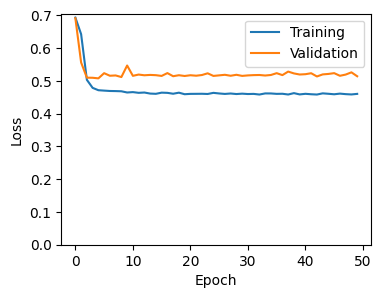

In [11]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0)
plt.legend();

In [13]:
from sklearn import metrics

with torch.no_grad():
    model.eval()
    pred_list = []
    labels_list = []
    for i, (data, target) in enumerate(valid_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        pred=output.cpu().detach().numpy().reshape(output.shape[0])
        labels=target.cpu().numpy().reshape(output.shape[0])
        pred_list.append(pred)
        labels_list.append(labels)
    labels = np.concatenate(labels_list)
    predictions = np.concatenate(pred_list)
    auc = metrics.roc_auc_score(labels, predictions)
    print('AUC on validation data ', auc)


AUC on validation data  0.830291584237914


### Part 3:  experiments with network architecture and hyperparameters


With the implementation you created in Part 2, your next task is to explore the space of hyperparameters and architecture choices to determine their effect on the performance of your three-layer network.  Choose three aspects of the network to explore (e.g. the learning rate, whether dropout is helpful, the choice of activation function, etc.).  Discuss your results.  Which aspects of the model seem to have the most effect on the accuracy of the network?  Do the best parameter values vary from dataset to dataset?  Is your three layer network able to match or exceed the performance of a single layer network?  Hint:  it should!

### Coding and reporting your results

In your notebook, I do not want to see repetitive code.  Such code belongs in a function!
In your reporting, make sure your results are clearly presented.  I recommend using a table format, and your table can be populated by your code.  pandas DataFrame objects render nicely in Jupyter notebooks.  Here's an example:


In [ ]:
import pandas as pd
import numpy as np

data = [
    ['AGL16', 'Dropout', 0.2, 0.92 ],
    ['GRF1', 'Dropout', 0.3, 0.9],
]
pd.DataFrame(data, columns = ['Dataset', 'Hyperparameter', 'Value', 'Accuracy'])

#### Grading

```
Part 1: dataset creation (20 pts)
Part 2: implementation of three layer network, early stopping, and multiple training (40 pts)
Part 3: experiments on network architecture (40 pts)
```